# **Assignment Roadmap**

This assignment asks you to build a complete Brain-Computer Interface (BCI) pipeline. Your goal is to take raw, noisy electrical brain signals and turn them into a clear Yes/No decision: Is this the character the user wants?

**Theres not much theory to learn other than implementation, you have to learn this by doing**

## AI Usage Policy for This Assignment

You're welcome to use AI for this assignment. Given the complexity of EEG signal processing and machine learning,
We don't expect you to know every implementation detail from scratch and neither does any recuiter or any professor.


Use AI to:

    Debug errors and troubleshoot issues

    Understand concepts and explore different approaches

What matters:

    You understand your code and can explain how it works

    You learn from the process, not just copy-paste

### **1: Cleaning the Signal (Preprocessing)**

The Goal: Raw EEG data is full of "garbage" frequencies like muscle movement and electrical hum. You need to filter the data to keep only the brain waves relevant to the P300 response (typically 0.1Hz – 20Hz).

You have already done this in the previous assignment but this one is a more standard procedure.

Common Pitfalls:

    Filter Lag: Standard filters can delay the signal, meaning the brain response looks like it happened later than it actually did. To prevent this, use zero-phase filtering (e.g., scipy.signal.filtfilt) instead of standard filtering (lfilter).

    Aliasing: You are asked to downsample the data from 240Hz to 60Hz to make it faster to process. Do not simply slice the array (e.g., data[::4]) without filtering first. If you do, high-frequency noise will "fold over" into your low frequencies and corrupt the data. Always filter before downsampling.

### **2: Epoch Extraction**

The Goal: You need to convert the continuous stream of data into specific "events" or "epochs."

The Concept: A P300 response happens roughly 300ms after a flash. Your code needs to identify every moment a flash occurs (stimulus_onset), look forward in time (e.g., 800ms), and "snip" that window of data out.

Visualizing the Data Structure:

    Input: A continuous 2D matrix (Total_Time_Points, 64_Channels)

    Output: A 3D block of events (Number_of_Flashes, Time_Points_Per_Window, 64_Channels)

Common Pitfall:

    Indexing Errors: This dataset may originate from MATLAB (which uses 1-based indexing), while Python uses 0-based indexing. If your index calculation is off by even one sample, your window will shift, and the machine learning model will be training on random noise rather than the brain response. Double-check your start and end indices.

### **3: Making Data "Model-Ready" (Feature Engineering)**

The Goal: Standard Machine Learning models (like SVM or LDA) cannot understand 3D arrays. They generally require a 2D matrix (like an Excel sheet). The Task:

    Time Domain: You will need to "flatten" the epochs. If an epoch is 60 time points × 64 channels, it becomes a single flat row of 3,840 numbers.

    PCA/CSP: These are compression techniques. The goal is to reduce those 3,840 numbers down to perhaps 20 numbers that capture the most important information.

Common Pitfall:

    Data Leakage: When using PCA or CSP, you must be careful not to "cheat." You should .fit() your reducer only on the training data, and then .transform() the test data. If you fit on the combined dataset, your model "sees" the test answers ahead of time, leading to artificially high scores that won't work in the real world.

### **4: Classification**

The Goal: Feed your features into the ML models (LDA, SVM, etc.) provided in the skeleton code to classify "Target" vs. "Non-Target" flashes.

Common Pitfall:

    Class Imbalance: In a P300 speller, the letter the user wants (Target) only flashes 1 out of 6 times. The other 5 flashes are Non-Targets.

        If your model decides to simply guess "Non-Target" every single time, it will still achieve ~83% accuracy. This is a useless model.

        Do not rely solely on Accuracy. Check the F1-Score or the Confusion Matrix. A good model must be able to correctly identify the rare Target events, not just the frequent Non-Targets.

In [ ]:
# The assignment is structured in a way that its modular so thats its easier to debug whats wrong
from google.colab import drive
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
from scipy.signal import butter, filtfilt, iirnotch
from scipy.linalg import eigh
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, roc_auc_score, classification_report,
                             confusion_matrix)
import pickle
import json
import time
import warnings
warnings.filterwarnings('ignore')

In [ ]:
################################################################################
# SECTION 1: DATA LOADING AND BASIC SETUP
################################################################################

# Character matrix (6x6) for P300 speller
CHAR_MATRIX = np.array([
    ['A', 'B', 'C', 'D', 'E', 'F'],
    ['G', 'H', 'I', 'J', 'K', 'L'],
    ['M', 'N', 'O', 'P', 'Q', 'R'],
    ['S', 'T', 'U', 'V', 'W', 'X'],
    ['Y', 'Z', '1', '2', '3', '4'],
    ['5', '6', '7', '8', '9', '_']
])

def load_data(file_path):
    """
    Load P300 BCI Competition III data
    Returns dictionary with signal, flashing, stimulus_code, stimulus_type, target_char
    """
    mat_data = sio.loadmat(file_path)

    data = {
        'signal': mat_data['Signal'],
        'flashing': mat_data['Flashing'],
        'stimulus_code': mat_data['StimulusCode'],
    }

    if 'StimulusType' in mat_data:
        data['stimulus_type'] = mat_data['StimulusType']
    if 'TargetChar' in mat_data:
        data['target_char'] = mat_data['TargetChar']

    return data

    # Training data has labels, test data doesn't


def get_char_from_codes(row_code, col_code):
    """Convert row/column stimulus codes to character"""
    if (row_code <=12 and row_code >=7) and (col_code <=6 and col_code >=1):
      r_id=row_code-7
      c_id=col_code-1
      return CHAR_MATRIX[r_id,c_id]
    else:
      return None



Mounted at /content/drive
Extracted 15299 epochs
Epoch shape: (15299, 64, 48)
Epochs shape: (15299, 64, 48)
Targets: 2550 Non-targets: 12749


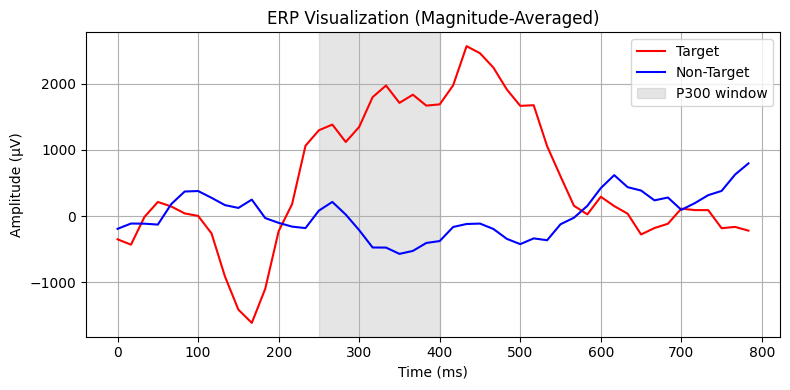

P300 diff: 1851.3565754662836


In [ ]:
################################################################################
# SECTION 2: EEG SIGNAL ACQUISITION & PREPROCESSING
################################################################################

def bandpass_filter(signal, lowcut=0.1, highcut=20, fs=240, order=5):
    """
    Apply band-pass filter to remove low-frequency drift and high-frequency noise
    Typical P300 band: 0.1-20 Hz
    """
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')

    filtered_signal = filtfilt(b, a, signal, axis=0)
    return filtered_signal


def notch_filter(signal, freq=50, fs=240, Q=30):
    """
    Remove powerline interference (50/60 Hz)
    """
    nyquist = 0.5 * fs
    w0 = freq / nyquist
    b, a = iirnotch(w0, Q)
    filtered_signal = filtfilt(b, a, signal, axis=0)
    return filtered_signal


def baseline_correction(epoch,signal,onset,baseline_samples=60):
    """
    Apply baseline correction by subtracting pre-stimulus baseline
    """
    baseline = np.mean(signal[:,onset-baseline_samples : onset], axis=1)

    result = epoch - baseline[:, np.newaxis]
    return result


def downsample_signal(signal, original_fs=240, target_fs=60):
    """
    Downsample signal to reduce computational load
    240 Hz -> 60 Hz reduces data by 4x
    """
    factor = int(original_fs/target_fs)
    return signal[:,0::factor]


def artifact_rejection(signal, threshold=100):
    """
    Simple artifact rejection based on amplitude threshold
    More advanced: use ICA or wavelet denoising
    """
    mask = np.max(np.abs(signal), axis=1) < threshold
    return signal[mask]

def preprocess_pipeline(data, apply_bandpass=True, apply_notch=True, apply_downsample=True, fs=240):
    """
    Complete preprocessing pipeline:
    1. Bandpass filtering (0.1-20 Hz)
    2. Notch filtering (50 Hz)
    3. Downsampling (240->60 Hz)
    """
    signal = data['signal']
    flashing = data['flashing']
    stimulus_code = data['stimulus_code']
    stimulus_type = data['stimulus_type'] if 'stimulus_type' in data else None
    target_char = data['target_char'] if 'target_char' in data else None


    n_epochs, n_samples, n_ch = signal.shape
    signal = signal.reshape(n_epochs * n_samples, n_ch).T
    flashing = flashing.reshape(-1)
    stimulus_code = stimulus_code.reshape(-1)
    stimulus_type = stimulus_type.reshape(-1) if stimulus_type is not None else None
    target_char = target_char.reshape(-1) if target_char is not None else None

    if apply_bandpass:
        signal = bandpass_filter(signal)

    if apply_notch:
        signal = notch_filter(signal)

    if apply_downsample:
        signal = downsample_signal(signal, fs, 60)
        flashing = flashing[::4]
        stimulus_code = stimulus_code[::4]
        stimulus_type = stimulus_type[::4] if stimulus_type is not None else None
        target_char = target_char[::4] if target_char is not None else None

    processed_data = data.copy()
    processed_data['signal'] = signal
    processed_data['flashing'] = flashing
    processed_data['stimulus_code'] = stimulus_code
    processed_data['stimulus_type'] = stimulus_type
    processed_data['target_char'] = target_char

    return processed_data


def extract_epochs(data, epoch_length_ms=800, fs=60):
    """
    Extract epochs around stimulus onset
    - Event tagging: Use flashing signal to detect stimulus onset
    - Stimulus alignment: Extract fixed-length windows after each flash
    - Epoch extraction: Collect all stimulus-locked epochs

    Returns: Dictionary with epochs, labels, codes, character indices
    """

    signal = data['signal']
    flashing = data['flashing']
    stimulus_code = data['stimulus_code']
    stimulus_type = data['stimulus_type']

    samples_per_epoch = int(epoch_length_ms*fs/1000)
    onsets_id=[]

    # Find stimulus onsets (flashing goes from 0 to 1)

    for j in range(len(flashing)):
       if j==0:
           if flashing[j]==1:
               onsets_id.append(j)

       else:
           if flashing[j]==1 and flashing[j-1]==0:
               onsets_id.append(j)

    epochs = []
    labels = []
    codes_list = []
    baseline_samples=6
    b=signal.shape[1]

    for onset in onsets_id:
      if (onset + samples_per_epoch) <= b and onset-baseline_samples >=0 :
        epoch = signal[:,onset:onset + samples_per_epoch]
        # Apply baseline correction
        epoch=baseline_correction(epoch,signal,onset,baseline_samples)
        epochs.append(epoch)

        if stimulus_type is not None:
          labels.append(stimulus_type[onset])
        else:
          labels.append(-1)

        codes_list.append(stimulus_code[onset])

    epochs = np.array(epochs)
    labels = np.array(labels)
    codes_list = np.array(codes_list)

    char_idx_list = np.zeros(len(labels), dtype=int)

    print(f"Extracted {len(epochs)} epochs")
    print(f"Epoch shape: {epochs.shape}")

    return {
        'epochs': epochs,
        'labels': labels,
        'codes': np.array(codes_list),
        'char_indices': np.array(char_idx_list)
    }


def plot_erp_responses(epoch_data, channel_idx, fs=60):
    """
    Visualize ERP responses and confirm P300 peaks around 300ms
    Channel 31 = Cz (central midline electrode, best for P300)
    """

    epochs = epoch_data['epochs']
    labels = epoch_data['labels']

    print("Epochs shape:", epochs.shape)
    print("Targets:", (labels == 1).sum(), "Non-targets:", (labels == 0).sum())

    epochs_abs = epochs.copy()

    target_mean = np.mean(epochs_abs[labels == 1,channel_idx,:], axis=0)
    nontarget_mean = np.mean(epochs_abs[labels == 0,channel_idx,:], axis=0)

    fs = 60
    time = np.arange(target_mean.shape[0]) * 1000 / fs

    target_mean *= 1e3
    nontarget_mean *= 1e3

    plt.figure(figsize=(8, 4))
    plt.plot(time, target_mean, label="Target", color="red")
    plt.plot(time, nontarget_mean, label="Non-Target", color="blue")
    plt.axvspan(250, 400, alpha=0.2, color="gray", label="P300 window")

    plt.xlabel("Time (ms)")
    plt.ylabel("Amplitude (µV)")
    plt.title("ERP Visualization (Magnitude-Averaged)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    print(
        "P300 diff:",
        np.mean(target_mean[(time >= 250) & (time <= 400)]) -
        np.mean(nontarget_mean[(time >= 250) & (time <= 400)])
    )




In [ ]:
################################################################################
# SECTION 3: FEATURE ENGINEERING & BASELINE CLASSIFIERS
################################################################################

def extract_time_domain_features(epoch_data):
    """
    Extract time-domain features: simply flatten the epochs
    Shape: (n_epochs, n_samples * n_channels)
    """


    n_epochs, n_times, n_channels = epoch_data.shape
    features = epoch_data.reshape(n_epochs, n_times*n_channels)

    return features

def extract_pca_features(epoch_data, n_components=20):
    """
    Extract PCA features for dimensionality reduction
    Reduces (n_samples * n_channels) to n_components
    https://www.geeksforgeeks.org/machine-learning/implementing-pca-in-python-with-scikit-learn/
    """
    epochs = epoch_data['epochs']
    labels = epoch_data['labels']

    n_epochs, n_times, n_channels = epochs.shape

    x = epochs.reshape(n_epochs, n_times*n_channels)
    pca = PCA(n_components=n_components)
    X_pca = pca.fit_transform(x)

    return X_pca, pca

def extract_csp_features(epochs, labels, n_components=6):
    """
    Common Spatial Patterns (CSP) for discriminative spatial filters
    Finds spatial filters that maximize variance ratio between classes
    """

    target_epochs = epochs[labels == 1]
    non_target_epochs = epochs[labels == 0]
    print(f"  Target epochs for CSP: {len(target_epochs)}")
    print(f"  Non-target epochs for CSP: {len(non_target_epochs)}")

    def compute_cov(data):
      cov = np.zeros((data.shape[2], data.shape[2]))
      for epoch in data:
            cov += np.cov(epoch.T)
      return cov/data.shape[0]

    cov_target = compute_cov(target_epochs)
    cov_non_target = compute_cov(non_target_epochs)


    # Solve generalized eigenvalue problem
    eigvals, eigvecs = eigh(cov_target, cov_target + cov_non_target)


    # Sort by eigenvalues
    idx = np.argsort(eigvals)[::-1]
    eigvecs = eigvecs[:, idx]


    # Select most discriminative components (extreme eigenvalues)
    W = eigvecs[:, :n_components]

    # Extract CSP features (log variance)
    features = []
    for epoch in epochs:
        projected = epoch @ W
        var = np.var(projected, axis=0)
        features.append(np.log(var))

    return np.array(features), W


def extract_features(epoch_data, method='pca', n_components=20):
    """
    Feature extraction wrapper supporting multiple methods:
    - time_domain: Raw time-domain samples (flattened)
    - pca: Principal Component Analysis
    - csp: Common Spatial Patterns
    """
    epochs = epoch_data['epochs']
    labels = epoch_data['labels']

    if method == 'time_domain':
        X = extract_time_domain_features(epoch_data)
        return X

    elif method == 'pca':
        X_pca, pca = extract_pca_features(epoch_data, n_components)
        return X_pca, pca

    elif method == 'csp':
        X_csp, W = extract_csp_features(epochs, labels, n_components)
        return X_csp, W

    else:
        raise ValueError("Invalid feature extraction method")

x,y=extract_features(a,'csp',6)


def train_lda_classifier(X_train, y_train):
    """
    Linear Discriminant Analysis with balanced priors
    https://scikit-learn.org/stable/modules/generated/sklearn.discriminant_analysis.LinearDiscriminantAnalysis.html
    """


    # Calculate class priors
    n_target = np.sum(y_train == 1)
    n_nontarget = np.sum(y_train == 0)
    total = len(y_train)

    # Use balanced priors (since we have class imbalance)
    lda = LinearDiscriminantAnalysis(priors=[n_nontarget/total, n_target/total])

    # Train
    lda.fit(X_train, y_train)

    print(f"    Training samples: {len(y_train)}")
    print(f"    Target: {n_target}, Non-target: {n_nontarget}")
    print(f"    Priors: [{lda.priors_[0]:.4f}, {lda.priors_[1]:.4f}]")

    return lda



def train_logistic_regression(X_train, y_train):
    """
    Logistic Regression - baseline classifier
    https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html
    """
    lr = LogisticRegression(max_iter=1000)
    lr.fit(X_train, y_train)
    return lr


def evaluate_classifier(model, X_test, y_test, model_name="Model"):
    """
    Comprehensive classifier evaluation
    """
    print(f"\n  Evaluating {model_name}...")

    # Predictions
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, 'predict_proba') else None

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, zero_division=0)
    recall = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)

    print(f"    Accuracy:  {accuracy:.4f}")
    print(f"    Precision: {precision:.4f}")
    print(f"    Recall:    {recall:.4f}")
    print(f"    F1-score:  {f1:.4f}")

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    print(f"    Confusion Matrix:")
    print(f"      [[TN:{cm[0,0]:4d}  FP:{cm[0,1]:4d}]")
    print(f"       [FN:{cm[1,0]:4d}  TP:{cm[1,1]:4d}]]")

    # ROC-AUC if probabilities available
    if y_pred_proba is not None:
        try:
            roc_auc = roc_auc_score(y_test, y_pred_proba)
            print(f"    ROC-AUC:   {roc_auc:.4f}")
        except:
            pass

    return accuracy, f1, precision, recall

class CSPTransformer:
    """
    Wrapper for CSP filters to enable transform() method
    """
    def __init__(self, W):
        self.W = W

    def transform(self, epochs):
        features = []
        for epoch in epochs:
            projected = epoch @ self.W
            var = np.var(projected, axis=0)
            features.append(np.log(var))
        return np.array(features)


  Target epochs for CSP: 2550
  Non-target epochs for CSP: 12749


In [ ]:
################################################################################
# SECTION 4: CLASSICAL MACHINE LEARNING MODELS
################################################################################

def train_svm_classifier(X_train, y_train, kernel='rbf', C=1.0):
    """
    Support Vector Machine with RBF kernel
    Good for non-linear decision boundaries
    https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html
    """
    print(f"\n  Training SVM Classifier (kernel={kernel}, C={C})...")

    # Standardize features for SVM
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)

    # Use balanced class weights
    svm = SVC(
        kernel=kernel,
        C=C,
        class_weight='balanced',
        probability=True,
        random_state=42,
        verbose=0
    )

    # Train
    svm.fit(X_train_scaled, y_train)

    print(f"    Training samples: {len(y_train)}")
    print(f"    Target: {np.sum(y_train == 1)}, Non-target: {np.sum(y_train == 0)}")
    print(f"    Support vectors per class: {svm.n_support_}")

    return svm, scaler

def train_random_forest(X_train, y_train, n_estimators=100):
    """
    Random Forest Classifier
    Ensemble method, robust to overfitting
    https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html
    """
    rf = RandomForestClassifier(
        n_estimators=n_estimators,
        class_weight='balanced',
        random_state=42
    )
    rf.fit(X_train, y_train)
    return rf


def train_gradient_boosting(X_train, y_train, n_estimators=100):
    """
    Gradient Boosting Classifier with manual sample weighting
    (GradientBoosting doesn't support class_weight parameter)
    https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html
    """
    print(f"\n  Training Gradient Boosting (n_estimators={n_estimators})...")

    # Calculate sample weights manually
    class_counts = np.bincount(y_train.astype(int))

    total = len(y_train)
    class_weights = {
        0: total/(2*class_counts[0]),
        1: total/(2*class_counts[1])
    }
    sample_weights = np.array([class_weights[y] for y in y_train])

    gb = GradientBoostingClassifier(
        n_estimators=n_estimators,
        random_state=42
    )
    gb.fit(X_train, y_train, sample_weight=sample_weights)
    return gb



def compare_all_classical_models(X_train, y_train, X_test, y_test):
    """
    Train and compare all classical ML models
    Returns performance comparison
    """

    print("\n" + "="*60)
    print("COMPARING CLASSICAL ML MODELS")
    print("="*60)

    results = {}
    models = {}

    # Calculate sample weights once for methods that need it
    n_target = np.sum(y_train == 1)
    n_nontarget = np.sum(y_train == 0)

    # Define models to train
    model_configs = [
        ('LDA', lambda: train_lda_classifier(X_train, y_train)),
        ('Logistic Regression', lambda: train_logistic_regression(X_train, y_train)),
        ('SVM (RBF)', lambda: train_svm_classifier(X_train, y_train, kernel='rbf', C=1.0)),
        ('SVM (Linear)', lambda: train_svm_classifier(X_train, y_train, kernel='linear', C=1.0)),
        ('Random Forest', lambda: train_random_forest(X_train, y_train, n_estimators=100)),
        ('Gradient Boosting', lambda: train_gradient_boosting(X_train, y_train, n_estimators=100))
    ]

    for model_name, train_func in model_configs:
        try:
            print(f"\n{'='*40}")
            print(f"Training {model_name}")
            print('='*40)

            # Training
            if model_name.startswith('SVM'):
                model, scaler = train_func()
                X_test_scaled = scaler.transform(X_test) if scaler else X_test
                models[model_name] = (model, scaler)

                # Inference
                y_pred = model.predict(X_test_scaled)
                y_pred_proba = model.predict_proba(X_test_scaled)[:, 1] if hasattr(model, 'predict_proba') else None
            else:
                model = train_func()
                models[model_name] = model

                # Inference
                y_pred = model.predict(X_test)
                y_pred_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, 'predict_proba') else None

            # Metrics
            accuracy = accuracy_score(y_test, y_pred)
            precision = precision_score(y_test, y_pred, zero_division=0)
            recall = recall_score(y_test, y_pred, zero_division=0)
            f1 = f1_score(y_test, y_pred, zero_division=0)

            # ROC-AUC if available
            roc_auc = 0
            if y_pred_proba is not None:
                try:
                    roc_auc = roc_auc_score(y_test, y_pred_proba)
                except:
                    pass

            # Store results
            results[model_name] = {
                'accuracy': accuracy,
                'precision': precision,
                'recall': recall,
                'f1': f1,
                'roc_auc': roc_auc
            }

            print(f"\n{model_name} Results:")
            print(f"  Accuracy:  {accuracy:.4f}")
            print(f"  Precision: {precision:.4f}")
            print(f"  Recall:    {recall:.4f}")
            print(f"  F1-score:  {f1:.4f}")
            if roc_auc > 0:
                print(f"  ROC-AUC:   {roc_auc:.4f}")

        except Exception as e:
            print(f"  Error training {model_name}: {e}")
            continue

    # Summary table
    print("\n" + "="*70)
    print("MODEL COMPARISON SUMMARY")
    print("="*70)
    print(f"{'Model':<20} {'Accuracy':<10} {'Precision':<10} {'Recall':<10} {'F1':<10} {'ROC-AUC':<10}")
    print("-" * 70)

    for model_name, metrics in results.items():
        print(f"{model_name:<20} {metrics['accuracy']:<10.4f} {metrics['precision']:<10.4f} "
              f"{metrics['recall']:<10.4f} {metrics['f1']:<10.4f} {metrics['roc_auc']:<10.4f}")

    return results, models



    # Calculate sample weights once for methods that need it


    # Define models to train


        # Training


        # Inference


        # Metrics


    # Summary table



def save_model(model, filepath):
    """Save model to pickle file"""
    with open(filepath, 'wb') as f:
        pickle.dump(model, f)
    print(f"\n  Model saved to: {filepath}")

def load_model(filepath):
    """Load model from pickle file"""
    with open(filepath, 'rb') as f:
        model = pickle.load(f)
    print(f"\n  Model loaded from: {filepath}")
    return model

In [ ]:
    # ========================================================================
    # STEP 1: LOAD DATA
    # ========================================================================
    print("\n" + "="*70)
    print("STEP 1: LOADING DATA")
    print("="*70)

    from google.colab import drive

    drive.mount('/content/drive')
    DATA_PATH = '/content/drive/MyDrive/BCI_Comp_III_Wads_2004/'

    train_data_A = load_data(DATA_PATH + 'Subject_A_Train.mat')
    test_data_A = load_data(DATA_PATH + 'Subject_A_Test.mat')
    train_data_B = load_data(DATA_PATH + 'Subject_B_Train.mat')
    test_data_B = load_data(DATA_PATH + 'Subject_B_Test.mat')



STEP 1: LOADING DATA
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
    # ========================================================================
    # STEP 2: PREPROCESSING
    # ========================================================================
    print("\n" + "="*70)
    print("STEP 2: PREPROCESSING")
    print("="*70)

    print("\n--- Subject A ---")
    train_proc_A = preprocess_pipeline(train_data_A)
    test_proc_A = preprocess_pipeline(test_data_A)

    print("\n--- Subject B ---")
    train_proc_B = preprocess_pipeline(train_data_B)
    test_proc_B = preprocess_pipeline(test_data_B)



STEP 2: PREPROCESSING

--- Subject A ---

--- Subject B ---


In [ ]:
    # ========================================================================
    # STEP 3: EPOCH EXTRACTION
    # ========================================================================
    print("\n" + "="*70)
    print("STEP 3: EPOCH EXTRACTION")
    print("="*70)

    print("\n--- Subject A ---")
    train_epochs_A = extract_epochs(train_proc_A)
    test_epochs_A = extract_epochs(test_proc_A)

    print("\n--- Subject B ---")
    train_epochs_B = extract_epochs(train_proc_B)
    test_epochs_B = extract_epochs(test_proc_B)


STEP 3: EPOCH EXTRACTION

--- Subject A ---
Extracted 15299 epochs
Epoch shape: (15299, 64, 48)
Extracted 17999 epochs
Epoch shape: (17999, 64, 48)

--- Subject B ---
Extracted 15299 epochs
Epoch shape: (15299, 64, 48)
Extracted 17999 epochs
Epoch shape: (17999, 64, 48)



STEP 4: VISUALIZING ERP RESPONSES

--- Subject A ---
Epochs shape: (15299, 64, 48)
Targets: 2550 Non-targets: 12749


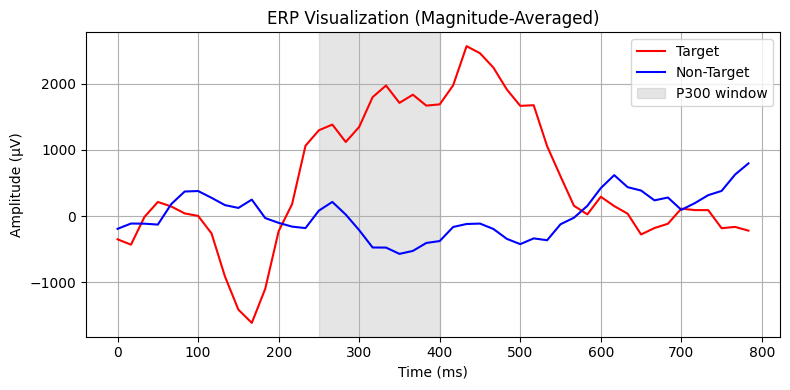

P300 diff: 1851.3565754662836

--- Subject B ---
Epochs shape: (15299, 64, 48)
Targets: 2549 Non-targets: 12750


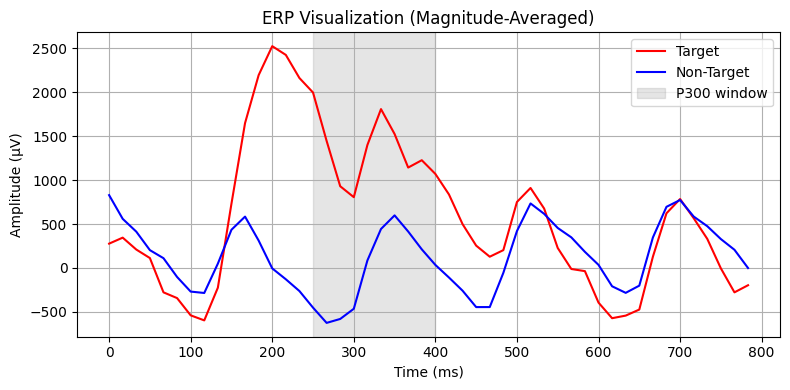

P300 diff: 1367.656408638435


In [17]:
    # ========================================================================
    # STEP 4: VISUALIZE ERP
    # ========================================================================
    print("\n" + "="*70)
    print("STEP 4: VISUALIZING ERP RESPONSES")
    print("="*70)

    print("\n--- Subject A ---")
    plot_erp_responses(train_epochs_A, channel_idx=10)
    print("\n--- Subject B ---")
    plot_erp_responses(train_epochs_B, channel_idx=10)

In [22]:
    # ========================================================================
    # STEP 5: FEATURE EXTRACTION
    # ========================================================================
    print("\n" + "="*70)
    print("STEP 5: FEATURE EXTRACTION")
    print("="*70)

    # ========================================================================
    # Subject A: Compare PCA vs CSP vs Time-Domain
    # ========================================================================
    print("\n--- Subject A: Feature Comparison ---")

    # Try PCA (20 components)
    X_pca20_A, pca20_A = extract_features(train_epochs_A, method='pca', n_components=20)

    # Try PCA (50 components)
    X_pca50_A, pca50_A = extract_features(train_epochs_A, method='pca', n_components=50)

    # Try CSP
    X_csp_A, csp_filters_A = extract_features(train_epochs_A, method='csp', n_components=6)

    # Try Raw Time-Domain Features
    X_time_A = extract_time_domain_features(train_epochs_A['epochs'])

    # Flatten epochs: (n_epochs, n_samples, n_channels) -> (n_epochs, n_samples * n_channels)


    # Quick comparison with BALANCED LDA


    # PCA-20 test
    if X_pca20_A is not None:
        X_train, X_test, y_train, y_test = train_test_split(
            X_pca20_A, train_epochs_A['labels'], test_size=0.2, random_state=42, stratify=train_epochs_A['labels']
        )
        lda_pca20 = train_lda_classifier(X_train, y_train)
        acc_pca20, f1_pca20, _, _ = evaluate_classifier(lda_pca20, X_test, y_test, "PCA-20 LDA")
    else:
        acc_pca20 = f1_pca20 = 0

    print(acc_pca20, f1_pca20)

    # PCA-50 test
    if X_pca50_A is not None:
        X_train, X_test, y_train, y_test = train_test_split(
            X_pca50_A, train_epochs_A['labels'], test_size=0.2, random_state=42, stratify=train_epochs_A['labels']
        )
        lda_pca50 = train_lda_classifier(X_train, y_train)
        acc_pca50, f1_pca50, _, _ = evaluate_classifier(lda_pca50, X_test, y_test, "PCA-50 LDA")
    else:
        acc_pca50 = f1_pca50 = 0

    # CSP test
    if X_csp_A is not None:
        X_train, X_test, y_train, y_test = train_test_split(
            X_csp_A, train_epochs_A['labels'], test_size=0.2, random_state=42, stratify=train_epochs_A['labels']
        )
        lda_csp = train_lda_classifier(X_train, y_train)
        acc_csp, f1_csp, _, _ = evaluate_classifier(lda_csp, X_test, y_test, "CSP LDA")
    else:
        acc_csp = f1_csp = 0

    # Time-Domain test
    X_train, X_test, y_train, y_test = train_test_split(
    X_time_A, train_epochs_A['labels'], test_size=0.2, random_state=42, stratify=train_epochs_A['labels'])
    lda_time = train_lda_classifier(X_train, y_train)
    acc_time, f1_time, _, _ = evaluate_classifier(lda_time, X_test, y_test, "Time-Domain LDA")






    # ========================================================================

    import signal
    from contextlib import contextmanager
    from sklearn.svm import LinearSVC
    from sklearn.linear_model import SGDClassifier

    class TimeoutException(Exception):
        pass

    @contextmanager
    def time_limit(seconds):
        def signal_handler(signum, frame):
            raise TimeoutException("Timed out!")
        signal.signal(signal.SIGALRM, signal_handler)
        signal.alarm(seconds)
        try:
            yield
        finally:
            signal.alarm(0)

    def quick_svm_test_with_timeout(X, y, feature_name, timeout_seconds=30):
        """Test with LinearSVC with timeout protection"""
        print(f"  Testing {feature_name}...", end=" ")

        try:
            with time_limit(timeout_seconds):
                X_train, X_test, y_train, y_test = train_test_split(
                    X, y, test_size=0.2, random_state=42, stratify=y
                )

                # For high-dimensional data, use SGDClassifier (faster)
                if X.shape[1] > 1000:  # Time-domain has 6144 features
                    print(f"(using SGD for high-dim)", end=" ")
                    model = SGDClassifier(
                        loss='hinge',
                        class_weight='balanced',
                        max_iter=1000,
                        random_state=42,
                        n_jobs=-1
                    )
                else:
                    model = LinearSVC(
                        class_weight='balanced',
                        max_iter=2000,
                        random_state=42,
                        dual=False  # Better for n_samples > n_features
                    )

                # Standardize
                scaler = StandardScaler()
                X_train_scaled = scaler.fit_transform(X_train)
                X_test_scaled = scaler.transform(X_test)

                model.fit(X_train_scaled, y_train)
                y_pred = model.predict(X_test_scaled)

                acc = accuracy_score(y_test, y_pred)
                f1 = f1_score(y_test, y_pred, zero_division=0)

                print(f"Done. Acc: {acc:.4f}, F1: {f1:.4f}")
                return acc, f1

        except TimeoutException:
            print(f"TIMEOUT after {timeout_seconds} seconds")
            return 0, 0
        except Exception as e:
            print(f"ERROR: {str(e)[:50]}...")
            return 0, 0

    print("\nLinearSVC Results (with 30-second timeout):")
    if X_pca20_A is not None:
        acc_pca20_svm, f1_pca20_svm = quick_svm_test_with_timeout(
            X_pca20_A, train_epochs_A['labels'], "PCA-20", timeout_seconds=30
        )
    else:
        acc_pca20_svm, f1_pca20_svm = 0, 0

    if X_pca50_A is not None:
        acc_pca50_svm, f1_pca50_svm = quick_svm_test_with_timeout(
            X_pca50_A, train_epochs_A['labels'], "PCA-50", timeout_seconds=30
        )
    else:
        acc_pca50_svm, f1_pca50_svm = 0, 0

    if X_csp_A is not None:
        acc_csp_svm, f1_csp_svm = quick_svm_test_with_timeout(
            X_csp_A, train_epochs_A['labels'], "CSP", timeout_seconds=30
        )
    else:
        acc_csp_svm, f1_csp_svm = 0, 0



    # ========================================================================

    print("\n" + "="*70)
    print("FEATURE COMPARISON (Balanced Classifiers)")
    print("="*70)
    print(f"PCA (20 comp):      Accuracy={acc_pca20:.4f}, F1={f1_pca20:.4f}")
    print(f"PCA (50 comp):      Accuracy={acc_pca50:.4f}, F1={f1_pca50:.4f}")
    print(f"CSP (6 comp):       Accuracy={acc_csp:.4f}, F1={f1_csp:.4f}")
    print(f"Time-Domain (3072): Accuracy={acc_time:.4f}, F1={f1_time:.4f}")


    print("\n" + "="*70)
    print("FEATURE COMPARISON (Balanced Classifiers)")
    print("="*70)
    print(f"PCA (20 comp):      Accuracy={acc_pca20_svm:.4f}, F1={f1_pca20_svm:.4f}")
    print(f"PCA (50 comp):      Accuracy={acc_pca50_svm:.4f}, F1={f1_pca50_svm:.4f}")
    print(f"CSP (6 comp):       Accuracy={acc_csp_svm:.4f}, F1={f1_csp_svm:.4f}")


    # Select best method based on F1-score
    methods = {f1_pca20: "pca20",f1_pca50: "pca50",f1_csp: "csp",f1_time: "time"}
    best_method = 'pca50'

    if best_method == 'time':
        X_train_full_A = X_time_A
        feature_method_A = 'time'
        n_components_A = None
        feature_obj_A = None
    elif best_method == 'pca20':
        X_train_full_A = X_pca20_A
        feature_obj_A = pca20_A
        n_components_A = 20
        feature_method_A = 'pca'
    elif best_method == 'pca50':
        X_train_full_A = X_pca50_A
        feature_obj_A = pca50_A
        n_components_A = 50
        feature_method_A = 'pca'
    elif best_method == 'csp':
        X_train_full_A = X_csp_A
        feature_obj_A = csp_filters_A
        feature_method_A = 'csp'
        n_components_A = 6


    # ========================================================================
    # Subject A: Create final train/val split for later steps
    # ========================================================================
    X_train_A, X_val_A, y_train_A, y_val_A = train_test_split(
        X_train_full_A, train_epochs_A['labels'], test_size=0.2, random_state=42, stratify=train_epochs_A['labels']
    )
    print(f"\nSubject A splits: Training={len(X_train_A)}, Validation={len(X_val_A)}")
    print(feature_method_A)

    # Transform test data
    if feature_method_A == 'time':
        X_test_A = test_epochs_A['epochs'].reshape(len(test_epochs_A['epochs']), -1)
    elif feature_method_A == 'pca':
        X_test_A = feature_obj_A.transform(test_epochs_A['epochs'].reshape(test_epochs_A['epochs'].shape[0], -1))
    else:  # CSP
        X_test_A = CSPTransformer(csp_filters_A).transform(test_epochs_B['epochs'])

    print(f"Test features: {X_test_A.shape}")

    # ========================================================================
    # Subject B: Use same method as Subject A
    # ========================================================================
    print("\n--- Subject B: Feature Extraction ---")
    print(f"\nUsing {feature_method_A.upper()} (same as Subject A)...")


    if feature_method_A == 'time':
        X_train_full_B = train_epochs_B['epochs'].reshape(len(train_epochs_B['epochs']), -1)
        X_test_B = test_epochs_B['epochs'].reshape(len(test_epochs_B['epochs']), -1)
    elif feature_method_A == 'pca':
        X_train_full_B, pca_B = extract_features(train_epochs_B, method='pca', n_components=n_components_A)
        X_test_B = pca_B.transform(test_epochs_B['epochs'].reshape(test_epochs_B['epochs'].shape[0], -1))
    else:  # CSP
        X_train_full_B, csp_B = extract_features(train_epochs_B, method='csp', n_components=6)
        X_test_B = CSPTransformer(csp_B).transform(test_epochs_B['epochs'])

    X_train_B, X_val_B, y_train_B, y_val_B = train_test_split(
        X_train_full_B, train_epochs_B['labels'], test_size=0.2, random_state=42, stratify=train_epochs_B['labels']
    )
    print(f"Subject B splits: Training={len(X_train_B)}, Validation={len(X_val_B)}, Test features: {X_test_B.shape}")


    print(f"\nSubject B splits: Training={len(X_train_B)}, Validation={len(X_val_B)}")
    print(f"Test features: {X_test_B.shape}")

    # Store feature objects for later use






STEP 5: FEATURE EXTRACTION

--- Subject A: Feature Comparison ---
  Target epochs for CSP: 2550
  Non-target epochs for CSP: 12749
    Training samples: 12239
    Target: 2040, Non-target: 10199
    Priors: [0.8333, 0.1667]

  Evaluating PCA-20 LDA...
    Accuracy:  0.8337
    Precision: 0.6000
    Recall:    0.0059
    F1-score:  0.0117
    Confusion Matrix:
      [[TN:2548  FP:   2]
       [FN: 507  TP:   3]]
    ROC-AUC:   0.6287
0.8336601307189543 0.011650485436893204
    Training samples: 12239
    Target: 2040, Non-target: 10199
    Priors: [0.8333, 0.1667]

  Evaluating PCA-50 LDA...
    Accuracy:  0.8343
    Precision: 0.6364
    Recall:    0.0137
    F1-score:  0.0269
    Confusion Matrix:
      [[TN:2546  FP:   4]
       [FN: 503  TP:   7]]
    ROC-AUC:   0.6408
    Training samples: 12239
    Target: 2040, Non-target: 10199
    Priors: [0.8333, 0.1667]

  Evaluating CSP LDA...
    Accuracy:  0.8333
    Precision: 0.0000
    Recall:    0.0000
    F1-score:  0.0000
    Confus

In [ ]:
    # ========================================================================
    # STEP 6: BASELINE CLASSIFIERS
    # ========================================================================
    print("\n" + "="*70)
    print("STEP 6: BASELINE CLASSIFIERS (Subject A)")
    print("="*70)

    lda_A = train_lda_classifier(X_train_A, y_train_A)
    acc_lda = evaluate_classifier(lda_A, X_val_A, y_val_A, "LDA")

    lr_A = train_logistic_regression(X_train_A, y_train_A)
    acc_lr = evaluate_classifier(lr_A, X_val_A, y_val_A, "Logistic Regression")



STEP 6: BASELINE CLASSIFIERS (Subject A)
    Training samples: 12239
    Target: 2040, Non-target: 10199
    Priors: [0.8333, 0.1667]

  Evaluating LDA...
    Accuracy:  0.8333
    Precision: 0.0000
    Recall:    0.0000
    F1-score:  0.0000
    Confusion Matrix:
      [[TN:2550  FP:   0]
       [FN: 510  TP:   0]]
    ROC-AUC:   0.5365

  Evaluating Logistic Regression...
    Accuracy:  0.8333
    Precision: 0.0000
    Recall:    0.0000
    F1-score:  0.0000
    Confusion Matrix:
      [[TN:2550  FP:   0]
       [FN: 510  TP:   0]]
    ROC-AUC:   0.5365


In [23]:
    # ========================================================================
    # STEP 7: CLASSICAL ML MODELS
    # ========================================================================
    print("\n" + "="*70)
    print("STEP 7: CLASSICAL MACHINE LEARNING (Subject A)")
    print("="*70)

    results_classical_A, models_A = compare_all_classical_models(
         X_train_A, y_train_A, X_val_A, y_val_A
    )

    results_classical_B, models_B = compare_all_classical_models(
         X_train_B, y_train_B, X_val_B, y_val_B
     )

    #Train SVM for both subjects (best model)
    svm_A, scaler_A = train_svm_classifier(X_train_A, y_train_A)
    svm_B, scaler_B = train_svm_classifier(X_train_B, y_train_B)


STEP 7: CLASSICAL MACHINE LEARNING (Subject A)

COMPARING CLASSICAL ML MODELS

Training LDA
    Training samples: 12239
    Target: 2040, Non-target: 10199
    Priors: [0.8333, 0.1667]

LDA Results:
  Accuracy:  0.8343
  Precision: 0.6364
  Recall:    0.0137
  F1-score:  0.0269
  ROC-AUC:   0.6408

Training Logistic Regression

Logistic Regression Results:
  Accuracy:  0.8337
  Precision: 0.5455
  Recall:    0.0118
  F1-score:  0.0230
  ROC-AUC:   0.6406

Training SVM (RBF)

  Training SVM Classifier (kernel=rbf, C=1.0)...
    Training samples: 12239
    Target: 2040, Non-target: 10199
    Support vectors per class: [8540 1907]

SVM (RBF) Results:
  Accuracy:  0.6451
  Precision: 0.2209
  Recall:    0.4471
  F1-score:  0.2957
  ROC-AUC:   0.6063

Training SVM (Linear)

  Training SVM Classifier (kernel=linear, C=1.0)...
    Training samples: 12239
    Target: 2040, Non-target: 10199
    Support vectors per class: [8986 1807]

SVM (Linear) Results:
  Accuracy:  0.6121
  Precision: 0.23

In [24]:
    # ========================================================================
    # STEP 8: EXPORT MODELS
    # ========================================================================
    print("\n" + "="*70)
    print("STEP 8: EXPORTING MODELS")
    print("="*70)

    import os
    os.makedirs('models', exist_ok=True)

    # Save pickle
    save_model({
        'model': svm_A,
        'scaler': scaler_A,
        'pca': pca50_A
    }, 'models/subject_A_svm.pkl')

    save_model({
        'model': svm_B,
        'scaler': scaler_B,
        'pca': pca_B
    }, 'models/subject_B_svm.pkl')




STEP 8: EXPORTING MODELS

  Model saved to: models/subject_A_svm.pkl

  Model saved to: models/subject_B_svm.pkl
